# Inlämningsuppgift: Del 2 - Adversarial input attack

Oliver Sjödin \
olsj21@student.bth.se

Adam Mützell \
admt21@student.bth.se

# Part 1: Initial setup

In [41]:
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

from art.utils import to_categorical
tf.compat.v1.enable_eager_execution()
#tf.compat.v1.disable_eager_execution()

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.18.0


In [42]:
# Loads the pretrained ResNet50 model
model = ResNet50(weights='imagenet')
# Number of classes in the model
print(f"Number of classes: {model.output_shape[1]}")

Number of classes: 1000


In [43]:

# Load the two images (koala & tractor)
init_image = image.load_img("images/koala.jpeg", target_size=(224, 224))
init_image = image.img_to_array(init_image)

target_image = image.load_img("images/tractor.jpeg", target_size=(224, 224))
target_image = image.img_to_array(target_image)

class_lookup = {105: "koala", 866: "tractor"}

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Init image class label: 105 (koala)


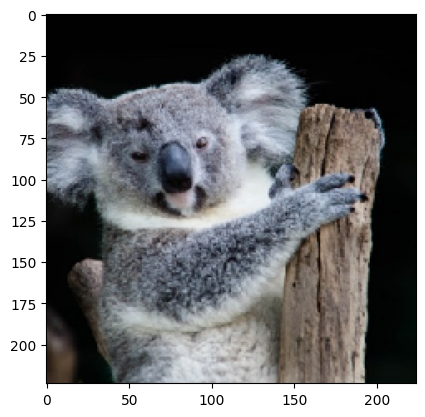

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
Target image class label: 866 (tractor)


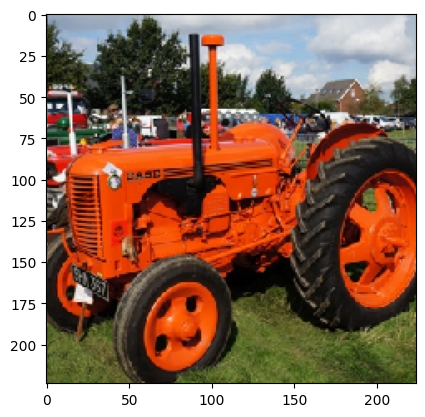

In [44]:

init_class_id = np.argmax(model.predict(np.array([init_image])))
print(f"Init image class label: {init_class_id} ({class_lookup[init_class_id]})")
plt.imshow(init_image.astype(np.uint))
plt.show()

target_class_id = np.argmax(model.predict(np.array([target_image])))
print(f"Target image class label: {target_class_id} ({class_lookup[target_class_id]})")
plt.imshow(target_image.astype(np.uint))
plt.show()

## Implementation av er attack

## Er kod för attacken

I cellerna nedan lägger ni in er egen kod för att genomföra attacken.

### Bibliotek

In [45]:
from matplotlib import pyplot as plt
import numpy as np

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BasicIterativeMethod

### Egna funktioner

In [46]:
def generate_adversarial_example(classifier, init_image, target_class_id):
    """
    Generates an adversarial example from an initial image and a target class id \n
    :param init_image: The initial image \n
    :param target_class_id: The target class id \n
    :return: The adversarial image \n
    """
    # Generate adversarial examples
    at = BasicIterativeMethod(classifier, eps=3, eps_step=0.1, max_iter=100, targeted=True, verbose=True)
    # Predict the class label of the adversarial example
    adversarial_image = at.generate(x=np.array([init_image]), y=to_categorical([target_class_id], 1000))
    return adversarial_image

def lookup_class_name(class_id, class_lookup):
    """
    Looks up the class name based on the class id \n
    :param class_id: The class id \n
    :param class_lookup: The lookup dictionary \n
    :return: The class name
    """
    return class_lookup[class_id][0]

### Förberedelser

In [47]:
tf.compat.v1.enable_eager_execution()

init_image = image.load_img("images/koala.jpeg", target_size=(224, 224))
init_image = image.img_to_array(init_image)

target_image = image.load_img("images/tractor.jpeg", target_size=(224, 224))
target_image = image.img_to_array(target_image)

np.random.seed(42)

with open("imagenet-classes.txt", "r") as f:
    classes_labels = f.readlines()

classes_labels = [c.replace("\n","").replace(" ","").split(",") for c in classes_labels]

### Modellering

In [48]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=1000, input_shape=(224, 224, 3), loss_object=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam())

### Attack

Attacken går ut på att använda FGSM iterativt i en metod som kallas för Basic Iterative Method (BIM) för att hitta en input vars klassificering är felaktig, samtidigt som den är så lik originalet som möjligt. Detta gör den genom att nyttja gradienten av modellen för att uppdatera pixelvärdena i inputen i den riktning vi önskar, i detta fall mot att klassifiera inputen till en traktor

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 1it [02:19, 139.94s/it]2024-11-15 10:01:04.478454: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Adversarial image class label: 866 (tractor)


/tmp/ipykernel_3269/3144758228.py:10: RuntimeWarning: invalid value encountered in cast
  plt.imshow(adversarial_image[0].astype(np.uint))


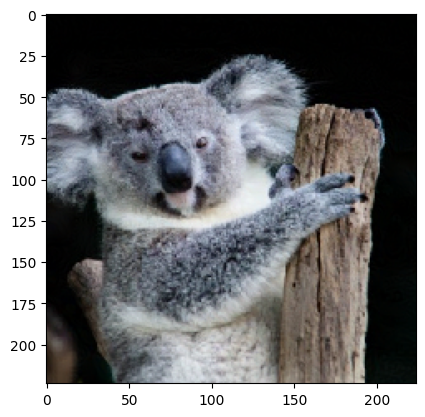

In [54]:
# Attackutförande

# Denna kan ta en stund att köra
adversarial_image = generate_adversarial_example(classifier, init_image, target_class_id)
adversarial_class_id = np.argmax(classifier.predict(adversarial_image))

diff = adversarial_image[0] - init_image
diff = (diff - diff.min()) / (diff.max() - diff.min())

plt.imshow(adversarial_image[0].astype(np.uint))
print(f"Adversarial image class label: {adversarial_class_id} ({lookup_class_name(adversarial_class_id, classes_labels)})")

### Attackresultat

Attacken lyckades få bilden att klassifieras som en traktor, även fast vi själva har svårt att se en skillnad mellan originalet och den attackerade bilden. Nedan illustrerar vi hur skillnaden kan synliggöras genom att subtrahera de två bilderna från varandra och sedan normalisera den.

Adversarial image class label: 866 (tractor)


/tmp/ipykernel_3269/1172517895.py:8: RuntimeWarning: invalid value encountered in cast
  axs[2].imshow(adversarial_image[0].astype(np.uint))


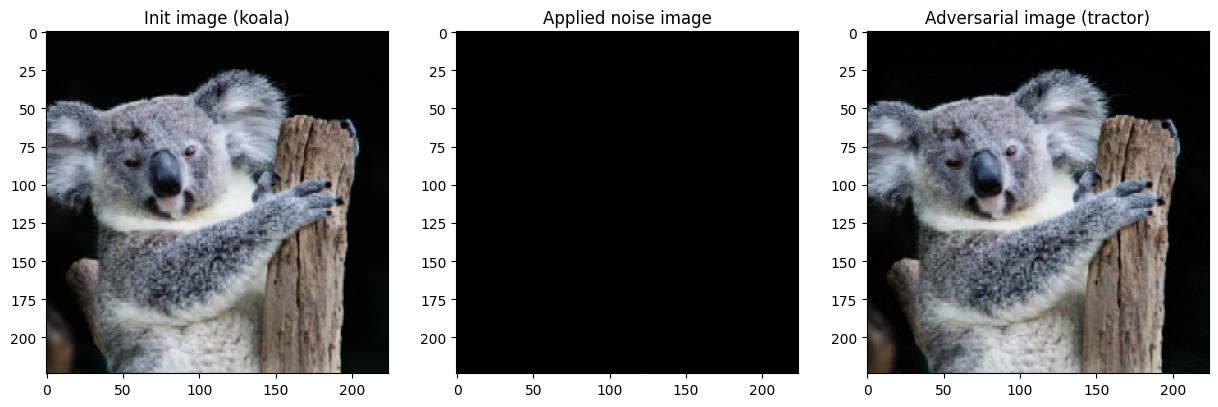

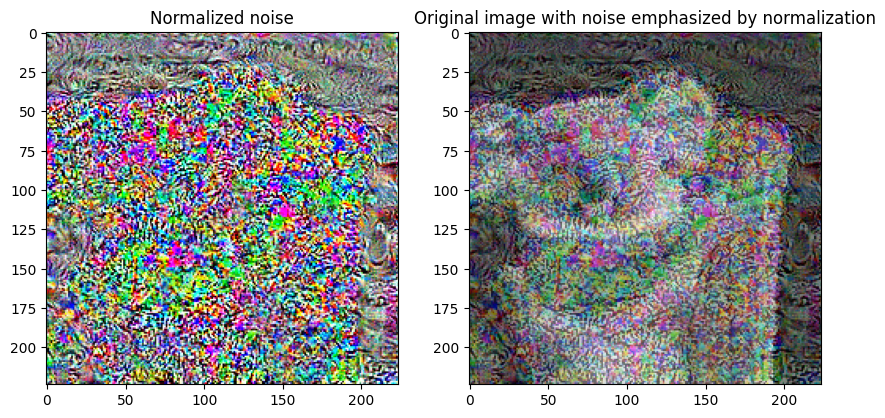

In [50]:
# Presentera attackens resultat m.h.a. kod här
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(init_image.astype(np.uint))
axs[0].set_title(f"Init image ({class_lookup[init_class_id]})")
axs[1].imshow(diff.astype(np.uint))
axs[1].set_title("Applied noise image")
axs[2].imshow(adversarial_image[0].astype(np.uint))
axs[2].set_title(f"Adversarial image ({class_lookup[adversarial_class_id]})")
plt.show()

# Add the original image and make it transparent
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 5))
axs2[1].imshow(init_image.astype(np.uint))
axs2[1].imshow(diff, alpha=0.5)
axs2[1].set_title("Original image with noise emphasized by normalization")
axs2[0].imshow(diff)
axs2[0].set_title("Normalized noise")
plt.show()

# Skyddsåtgärder

### Egna funktioner

In [51]:
def generate_restored_image(adv_image, noise):
    """
    Generates a defence for an adversarial image \n
    :param adv_image: The adversarial image \n
    :return: The defended image \n
    """
    defence_noise = np.random.normal(0, noise, size=adv_image[0].shape)
    defended_image = adversarial_image + defence_noise
    return defended_image

def get_defence_noise(init_image, restored_image):
    """
    Generates the noise that was added to the adversarial image to restore it using random normally distributed noise \n
    :param init_image: The initial image \n
    :param restored_image: The restored image \n
    :return: The noise
    """
    diff = restored_image[0] - init_image
    diff = (diff - diff.min()) / (diff.max() - diff.min())
    return diff

### Förberedelser

### Skydd

Vi applicerar ett slumpartart filter baserat på normalfördelning för att skydda modellen mot denna Basic Iterative Method (BIM) attacken. Idéen är att "sudda ut" felen som attacken lägger till. 

In [52]:
# Implementation av skyddsåtgärd
noise = 5 # Standard deviation of the noise
defence_image = generate_restored_image(adversarial_image, noise)
pred = np.argmax(classifier.predict(defence_image))
class_name = lookup_class_name(pred, classes_labels)
print(f"Predicted class: {pred} ({class_name})")

Predicted class: 105 (koala)


### Skyddsresultat

Vi ser att skyddet klarar av att skapa en bild som blir rätt klassifierad. I detta exempel satte vi standardavvikelsen på filtret till 5.0, vilket är ändå en hyfsat liten påverkan på bilden då alla pixlar har RGB-värden mellan 0 och 255. Nedan visar vi att det kan ha stor betydelse kring vilken standardavvikelse som används.

/tmp/ipykernel_3269/1615539128.py:7: RuntimeWarning: invalid value encountered in cast
  axs[i][0].imshow(defence_image[0].astype(np.uint))
/tmp/ipykernel_3269/1615539128.py:10: RuntimeWarning: invalid value encountered in cast
  axs[i][2].imshow((init_image-defence_image[0]).astype(np.uint))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..391].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..488].
Clipping input data to the valid range for imshow with R

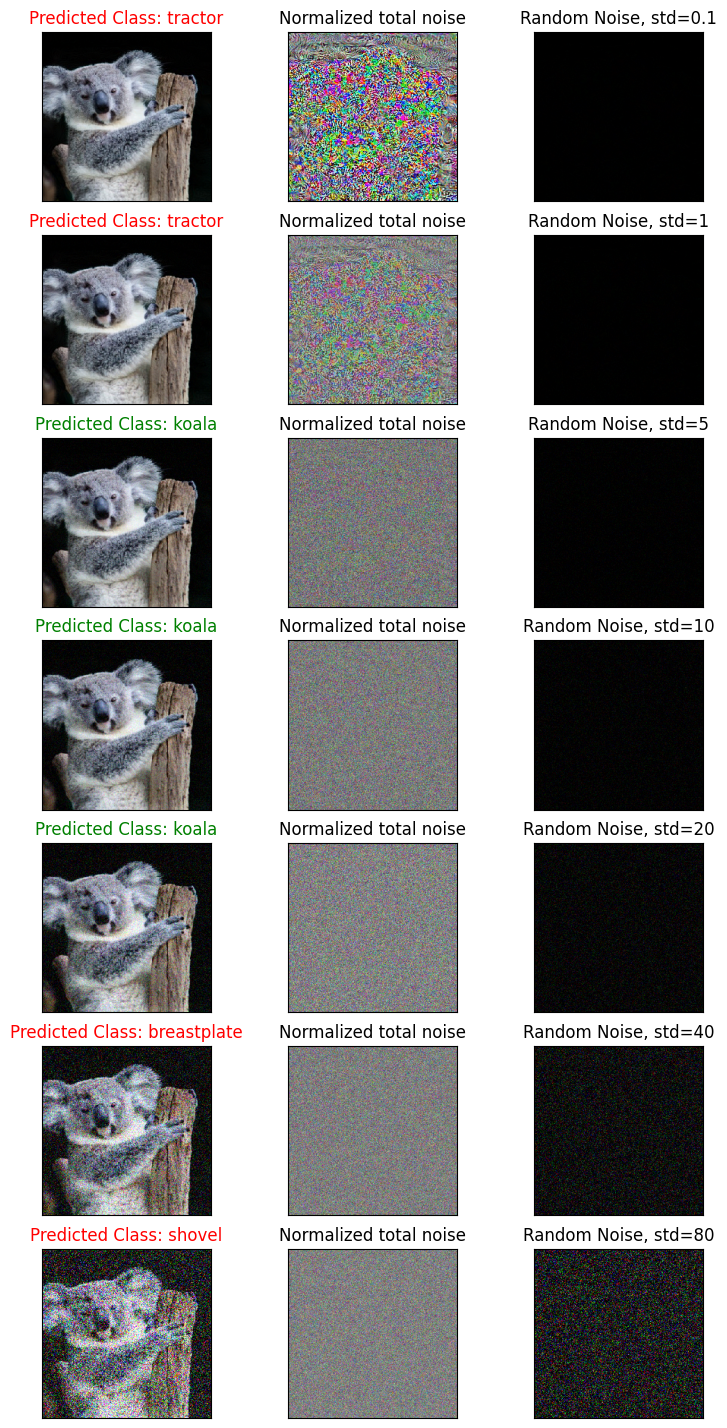

In [53]:
# Presentera skyddåtgärdens resultat m.h.a. kod här
noises = [0.1, 1, 5, 10, 20, 40, 80]
fig, axs = plt.subplots(len(noises), 3, figsize=(9, 18), sharex=True, sharey=True)
# fig.suptitle("Defence images")
for i, noise in enumerate(noises):
    defence_image = generate_restored_image(adversarial_image, noise)
    axs[i][0].imshow(defence_image[0].astype(np.uint))
    noise_image = get_defence_noise(init_image, defence_image)
    axs[i][1].imshow(noise_image)
    axs[i][2].imshow((init_image-defence_image[0]).astype(np.uint))
    axs[i][0].xaxis.set_visible(False)
    axs[i][1].xaxis.set_visible(False)
    axs[i][1].yaxis.set_visible(False)
    axs[i][0].yaxis.set_visible(False)
    axs[i][2].yaxis.set_visible(False)
    axs[i][2].xaxis.set_visible(False)
    pred = np.argmax(classifier.predict(defence_image))
    class_name = lookup_class_name(pred, classes_labels)
    # Make disp name red, unless it is koala, in which case make it green
    color = "red" if class_name != "koala" else "green"
    axs[i][0].set_title(f"Predicted Class: {class_name}", color=color)
    axs[i][1].set_title(f"Normalized total noise")
    axs[i][2].set_title(f"Random Noise, std={noise}")

# Referenser

ART: https://github.com/Trusted-AI/adversarial-robustness-toolbox